# Neural network for regression with PyTorch!

In [45]:
import torch
import torch.nn as nn
import pandas as pd

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.datasets import fetch_california_housing

from sklearn.metrics import mean_squared_error

Show device

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using {device} device")

Using cpu device


# Load data

In [47]:
BASE_PATH = '.'

def load_data():
    """
    Load train, test and validate data frames
    """
    train_df = pd.read_csv(f'{BASE_PATH}/train.csv', index_col='id')
    test_df = pd.read_csv(f'{BASE_PATH}/test.csv', index_col='id')

    bunch = fetch_california_housing(as_frame=True)
    validate_df = bunch['frame']

    train_df = pd.concat([train_df, validate_df])

    return train_df, test_df, validate_df

In [48]:
train_df, test_df, validate_df = load_data()

In [49]:
print(train_df.shape)
print(validate_df.shape)
print(test_df.shape)

(57777, 9)
(20640, 9)
(24759, 8)


# Create custom Dataset

In [50]:
class HousingDataset(Dataset):

    def __init__(self, x, y=None):
        self.x = torch.tensor(x.values, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).to(device) if y is not None else None

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] if self.y is not None else torch.empty((1, 1), dtype=torch.float32)

In [51]:
TARGET = 'MedHouseVal'
FEATURES = [col for col in train_df.columns if col not in ['id', TARGET]]

print(f'Features count: {len(FEATURES)}')

train_dataset = HousingDataset(train_df[FEATURES], train_df[TARGET])
test_dataset = HousingDataset(test_df[FEATURES])
validate_dataset = HousingDataset(validate_df[FEATURES], validate_df[TARGET])

Features count: 8


In [52]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Create network

In [53]:
class NeuralNetwork(nn.Module):
    """
    Simple neural network
    """

    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.head = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.head(x)

        return logits

In [54]:
learning_rate = 1e-3
epochs = 100

In [55]:
model = NeuralNetwork().to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model

In [56]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Optimization
    """
    size = len(dataloader.dataset)
    loss_history = []
    score_history = []
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X).squeeze(1)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        
        if batch % 1000 == 0:            
            loss, current = loss.item(), batch * len(X)
            loss_history.append(loss)

            score = mean_squared_error(y.cpu().detach().numpy().tolist(), pred.cpu().detach().numpy().tolist(), squared=False)
            score_history.append(score)
        
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
            
    return loss_history, score_history


def validate_loop(dataloader, model, loss_fn):
    """
    Evaluates
    """
    num_batches = len(dataloader)
    validate_loss = 0

    final_predictions = []
    final_targets = []
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).squeeze(1)
            validate_loss += loss_fn(pred, y).item()

            final_predictions.extend(pred.cpu().detach().numpy().tolist())
            final_targets.extend(y.cpu().detach().numpy().tolist())

    validate_loss /= num_batches
    score = mean_squared_error(final_targets, final_predictions, squared=False)
    print(f"Validate Error: \n RMSE accuracy: {(100 * score):>0.1f}%, Avg loss: {validate_loss:>8f} \n")
    
def predict(dataloader, model):
    """
    predict
    """
    final_predictions = []

    model.eval()
    with torch.no_grad():
        for X, _ in dataloader:
            pred = model(X).squeeze(1)

            final_predictions.extend(pred.cpu().detach().numpy().tolist())

    return final_predictions

In [57]:
loss_history = []
score_history = []
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    epoch_loss_history, epoch_score_history = train_loop(train_dataloader, model, loss_fn, optimizer)
    loss_history.extend(epoch_loss_history)
    score_history.extend(epoch_score_history)
#     validate_loop(validate_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 7.492653  [    0/57777]
loss: 1.444379  [32000/57777]
Epoch 2
-------------------------------
loss: 0.651685  [    0/57777]
loss: 0.715972  [32000/57777]
Epoch 3
-------------------------------
loss: 0.386207  [    0/57777]
loss: 0.650290  [32000/57777]
Epoch 4
-------------------------------
loss: 0.597378  [    0/57777]


KeyboardInterrupt: 

# Show plots

In [40]:
import matplotlib.pyplot as plt
 

def show_plots(loss_list, score_list, title):
  plt.figure(figsize=(15, 9))
  plt.plot(loss_list, label="Loss history")
  plt.plot(score_list, label="RMSE history")
  plt.legend(loc='best')
  plt.xlabel('Time')
  plt.ylabel(title)
  plt.title(title)
  plt.show()

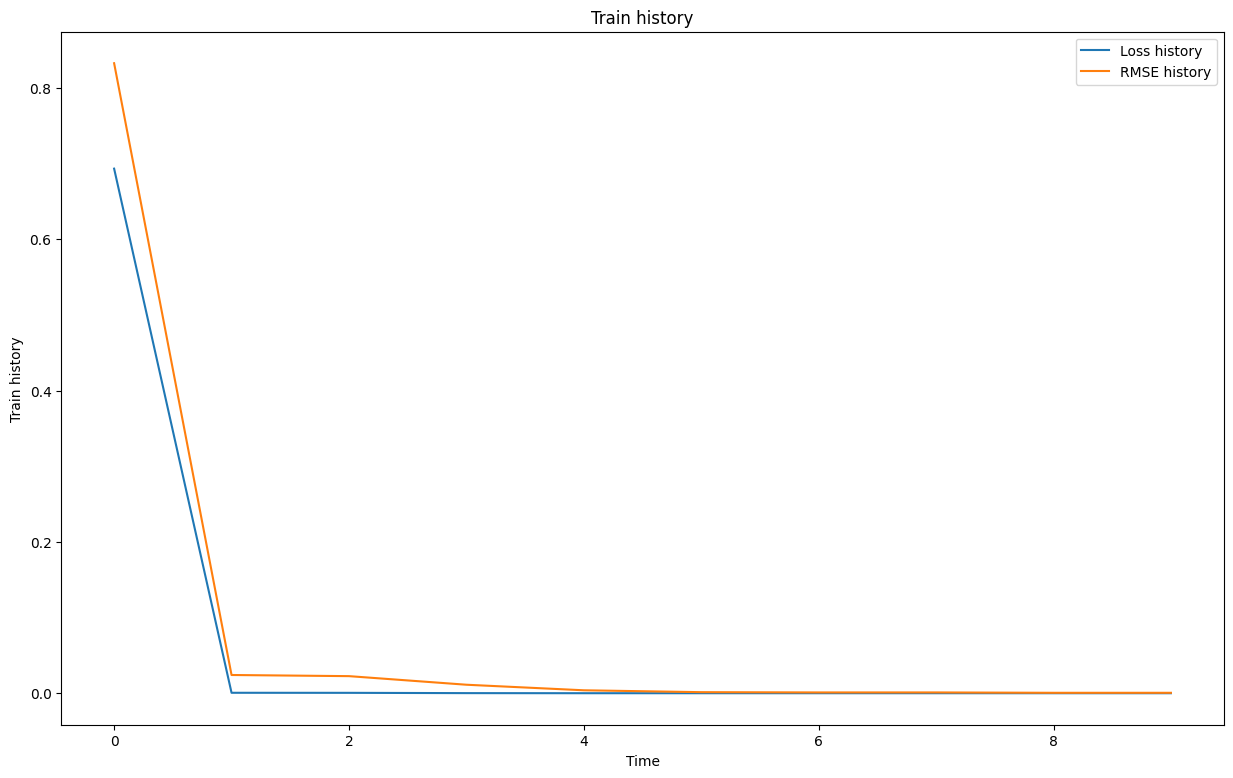

In [41]:
show_plots(loss_history, score_history, 'Train history')

# Submission

In [42]:
def save_submission(y_pred):  
    df = pd.read_csv('test.csv')

    submission = df.loc[:, ('id',)]
    submission[TARGET] = y_pred
    
    assert len(y_pred) == submission.shape[0]
    assert 2 == submission.shape[1]
    
    submission.to_csv("submission.csv",index=False)
    return submission

In [43]:
y_pred = predict(test_dataloader, model)
save_submission(y_pred).head()

,id,MedHouseVal
0,37137,0.979683
1,37138,0.979828
2,37139,0.979780
3,37140,0.980066
4,37141,0.979795


If you found this notebook useful, please upvote! Happy New Year!